<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/2024-1/notebooks/0b_autodiff_pytorch_completo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diferenciación automática
La [diferenciación automática](https://en.wikipedia.org/wiki/Automatic_differentiation) es un método para evaluar derivadas de funciones representadas como programas [[Automatic Differentiation in Machine Learning: a Survey, Baydin et. al, 2018](https://arxiv.org/abs/1502.05767)].

![Diferenciación automática](https://gowrishankar.info/blog/automatic-differentiation-using-gradient-tapes/auto_diff.png)

Fuente: [Automatic Differentiation in Machine Learning: a Survey, Baydin et. al, 2018](https://arxiv.org/abs/1502.05767).

In [1]:
import torch as th
from torch import nn

import numpy as np
import matplotlib.pyplot as plt

# Por reproducibilidad
th.manual_seed(42)
np.random.seed(42)

## Clase `Parameter`
La clase [`Parameter`](https://www.tensorflow.org/api_docs/python/tf/Variable) del módulo `nn` de PyTorch define una subclase de `Tensor` que se emplea comúnmente para representar los parámetros que modifican los algoritmos de aprendizaje para generar un modelo. Las instancias de `Parameter` que se definen dentro de una subclase de `Module` del módulo de `nn` se agregan a su lista de parámetros a optimizar.

El constructor de la clase `Parameter` recibe un tensor como argumento con el que se crea la instancia.


In [2]:
print(f'Con un tensor de ceros: {nn.parameter.Parameter(th.zeros((10,5)))}')
print(f'Con un tensor aleatorio: {nn.parameter.Parameter(th.rand((10,5)))}')
print(f'Con un arreglo de NumPy: {nn.parameter.Parameter(th.rand(5,5))}')
print(f'Con una lista: {nn.parameter.Parameter(th.tensor([[1.0, 2.0], [3.0, 4.0]]))}')

Con un tensor de ceros: Parameter containing:
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], requires_grad=True)
Con un tensor aleatorio: Parameter containing:
tensor([[0.8823, 0.9150, 0.3829, 0.9593, 0.3904],
        [0.6009, 0.2566, 0.7936, 0.9408, 0.1332],
        [0.9346, 0.5936, 0.8694, 0.5677, 0.7411],
        [0.4294, 0.8854, 0.5739, 0.2666, 0.6274],
        [0.2696, 0.4414, 0.2969, 0.8317, 0.1053],
        [0.2695, 0.3588, 0.1994, 0.5472, 0.0062],
        [0.9516, 0.0753, 0.8860, 0.5832, 0.3376],
        [0.8090, 0.5779, 0.9040, 0.5547, 0.3423],
        [0.6343, 0.3644, 0.7104, 0.9464, 0.7890],
        [0.2814, 0.7886, 0.5895, 0.7539, 0.1952]], requires_grad=True)
Con un arreglo de NumPy: Parameter containing:
tensor([[0.0050, 0

Podemos realizar cualquier operación tensorial con una instancia de `Parameter`, ya sea con otras instancias de `Parameter` o `Tensor`. El resultado de la operación es una instancia de `Tensor`.

In [3]:
param = th.nn.parameter.Parameter(th.zeros((10,5)))

print(f'Transpuesta: {param.T}')
print(f'Suma: {param + th.ones_like(param)}')
print(f'Multiplicación elemento a elemento: {param * th.zeros_like(param)}')
print(f'Multiplicación: {param @ th.rand_like(param).T}')

Transpuesta: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<PermuteBackward0>)
Suma: tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]], grad_fn=<AddBackward0>)
Multiplicación elemento a elemento: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], grad_fn=<MulBackward0>)
Multiplicación: 

## Diferenciación automática en PyTorch
PyTorch puede diferenciar automáticamente secuencias de operaciones con instancias de `Tensor` o `Parameter`. Para ello se mantiene una gráfica de cómputo, la cual se va generando de manera dinámica conforme se ejecutan operaciones con instancias que tienen la propiedad `requires_grad` en verdadero (solo ten cuidado con las operaciones _in-place_). Por defecto, todas las instancias de `Parameter` tienen esta propiedad en verdadero y las instancias de `Tensor` en falso.

In [4]:
ten = th.linspace(start=-10, end=10, steps=100)
print(param.requires_grad)
print(ten.requires_grad)

True
False


Es posible cambiar el valor de esta propiedad en una instancia usando el método `requires_grad_` (_in-place_).

In [5]:
param.requires_grad_(False)
ten.requires_grad_(True)
print(param.requires_grad)
print(ten.requires_grad)

False
True


Para modificar el contenido de una instancia de `Parameter` es necesario especificar que no se registre la operación usando el ámbito `no_grad`.

In [6]:
with th.no_grad():
  param[0, 0] = 1
print(f'Nuevo valor del elemento (0,0) = {param[0, 0]}')

Nuevo valor del elemento (0,0) = 1.0


En general, existen métodos para instancias tanto de `Parameter` como de `Tensor` que modifican el contenido _in-place_. Los nombres de estos métodos usualmente terminan con un guión bajo. Tal es el caso de `add_` y `mul_`, que suman y multiplican un tensor. Debido a que estas operaciones no deben registrarse cuando las instancias de `Parameter` o `Tensor` tienen `requires_grad = True`, las ejecutamos dentro del ámbito `no_grad`.

In [7]:
with th.no_grad():
  print(f'Suma matriz de unos a parámetros: {param.add_(th.ones_like(param))}')
  print(f'Resta matriz de unos a parámetros: {param.subtract_(th.ones_like(param))}')
  print(f'Multiplica parámetros por matriz de dos: {param.mul_(2 * th.ones_like(param))}')

Suma matriz de unos a parámetros: Parameter containing:
tensor([[2., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])
Resta matriz de unos a parámetros: Parameter containing:
tensor([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
Multiplica parámetros por matriz de dos: Parameter containing:
tensor([[2., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0.,

Para obtener el gradiente de una [función escalar](https://en.wiktionary.org/wiki/scalar_function) respecto a un tensor que está siendo contemplado se debe llamar al método `backward`.

Por ejemplo, considera la siguiente función:

$$
f(x, y) = 2x^3 + 3y^2 + c
$$

![](https://camo.githubusercontent.com/32e5a6b4cf8ad981ba5b19c9a5fab02fdc14d409237f774034d23536a731ae5c/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f626572656d6c2f6961702f6d61737465722f6669672f6175746f646966665f6578616d706c652e737667)

Ejemplo y figura de Berenice Montalvo-Lezama y Ricardo Montalvo-Lezama (tomado de [https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2022-1/notebooks/1c_pytorch.ipynb](https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2022-1/notebooks/1c_pytorch.ipynb)).

Evaluando esta función en $x = 2$, $y = 3$ y $c = 1.0$, tenemos

$$
f(2, 3) = 2\cdot (2)^3 + 3 \cdot (3)^2 + 1 = 44
$$

Las derivadas partiales evaluadas en estos puntos estarían dadas por
$$
\begin{align}
\frac{\partial f}{\partial x} = 6x^2 = 6 \cdot (2)^2 = 24\\
\frac{\partial f}{\partial y} = 6y = 6 (3) = 18
\end{align}
$$

In [8]:
x = th.tensor(2.0, requires_grad=True)
y = th.tensor(3.0, requires_grad=True)
c = th.tensor(1.0)

f = 2 * x**3 + 3 * y**2 + c
f.backward()

Cuando se invoca a este método, se calculan los gradientes de la función respecto al tensor correspondiente y se acumulan en el tensor `grad` que es una propiedad de todas las instancia de `Tensor` y `Parameter`.

In [9]:
print(f'Función evaluada = {f}')
print(f'Derivada respecto a: x = {x.grad}, y = {y.grad} y c = {c.grad}')

Función evaluada = 44.0
Derivada respecto a: x = 24.0, y = 18.0 y c = None


Además, al construir la gráfica de cómputo de una operación, PyTorch almacena la función de retropropagación correspondiente en la propiedad `grad_fn` del tensor resultante. Para el ejemplo anterior, esta sería:

In [10]:
a = x**3
b = 2 * a

d = y**2
e = 3 * d

g = b + e
f = g + c
print(f'Función de retropropagación para a = {a.grad_fn}')
print(f'Función de retropropagación para b = {b.grad_fn}')
print(f'Función de retropropagación para c = {c.grad_fn}')
print(f'Función de retropropagación para d = {d.grad_fn}')
print(f'Función de retropropagación para e = {e.grad_fn}')
print(f'Función de retropropagación para g = {g.grad_fn}')
print(f'Función de retropropagación para f = {f.grad_fn}')

Función de retropropagación para a = <PowBackward0 object at 0x7c6bd6c8b040>
Función de retropropagación para b = <MulBackward0 object at 0x7c6bd6c8bd00>
Función de retropropagación para c = None
Función de retropropagación para d = <PowBackward0 object at 0x7c6be428c610>
Función de retropropagación para e = <MulBackward0 object at 0x7c6be428ccd0>
Función de retropropagación para g = <AddBackward0 object at 0x7c6be428d4e0>
Función de retropropagación para f = <AddBackward0 object at 0x7c6be428c220>


Podemos evaluar estas funciones:

In [11]:
print(f'Retropropagación para a = {a.grad_fn(th.tensor(1.))}')
print(f'Retropropagación para b = {b.grad_fn(th.tensor(1.))}')
print(f'Retropropagación para a y b = {a.grad_fn(b.grad_fn(th.tensor(1.))[0])}')
print(f'Retropropagación para d = {d.grad_fn(th.tensor(1.))}')
print(f'Retropropagación para e = {e.grad_fn(th.tensor(1.))}')
print(f'Retropropagación para d y e = {d.grad_fn(e.grad_fn(th.tensor(1.))[0])}')
print(f'Retropropagación para g = {g.grad_fn(th.tensor(1.))}')
print(f'Retropropagación para f = {f.grad_fn(th.tensor(1.))}')

Retropropagación para a = 12.0
Retropropagación para b = (tensor(2.), None)
Retropropagación para a y b = 24.0
Retropropagación para d = 6.0
Retropropagación para e = (tensor(3.), None)
Retropropagación para d y e = 18.0
Retropropagación para g = (tensor(1.), tensor(1.))
Retropropagación para f = (tensor(1.), None)


In [12]:
print(a.grad_fn(b.grad_fn(g.grad_fn(f.grad_fn(th.tensor(1.))[0])[0])[0]))
print(d.grad_fn(e.grad_fn(g.grad_fn(f.grad_fn(th.tensor(1.))[0])[0])[0]))

tensor(24., grad_fn=<MulBackward0>)
tensor(18., grad_fn=<MulBackward0>)


Cuando se llama al método `backward` se van evaluando las funciones de retropropagación en la gráfica de cómputo desde el último nodo hacia atrás usando la propiedad `next_functions` de `grad_fn` hasta obtener los gradientes de los tensores correspondientes en los nodos hoja. Nota que en algunos casos es necesario mantener los resultados intermedios para poder evaluar esta función y obtener el gradiente correspondiente.

Consideremos ahora la función:

$$
g(\mathbf{m}) =  \sum_{j=1}^d m_j^2
$$

La derivada parcial de esta función respecto a cada elemento de $\mathbf{m}$ estaría dada por

$$
\frac{\partial g(\mathbf{m})}{\partial m_j} = 2\cdot m_j
$$

Definimos esta función, la evalúamos para 100 valores entre -10 y 10 y obtenemos las derivadas parciales respecto a cada uno de los 100 valores (gradiente) usando el método `backward`:

In [13]:
m = th.linspace(start=-10, end=10, steps=100, requires_grad=True)
g = (m**2).sum()
g.backward()

print(f'Función evaluada = {g}, retropropagación = {g.grad_fn}')
print(f'Derivada respecto a cada valor de m = {m.grad}')

Función evaluada = 3400.67333984375, retropropagación = <SumBackward0 object at 0x7c6be428caf0>
Derivada respecto a cada valor de m = tensor([-20.0000, -19.5960, -19.1919, -18.7879, -18.3838, -17.9798, -17.5758,
        -17.1717, -16.7677, -16.3636, -15.9596, -15.5556, -15.1515, -14.7475,
        -14.3434, -13.9394, -13.5354, -13.1313, -12.7273, -12.3232, -11.9192,
        -11.5152, -11.1111, -10.7071, -10.3030,  -9.8990,  -9.4949,  -9.0909,
         -8.6869,  -8.2828,  -7.8788,  -7.4747,  -7.0707,  -6.6667,  -6.2626,
         -5.8586,  -5.4545,  -5.0505,  -4.6465,  -4.2424,  -3.8384,  -3.4343,
         -3.0303,  -2.6263,  -2.2222,  -1.8182,  -1.4141,  -1.0101,  -0.6061,
         -0.2020,   0.2020,   0.6061,   1.0101,   1.4141,   1.8182,   2.2222,
          2.6263,   3.0303,   3.4343,   3.8384,   4.2424,   4.6465,   5.0505,
          5.4545,   5.8586,   6.2626,   6.6667,   7.0707,   7.4747,   7.8788,
          8.2828,   8.6869,   9.0909,   9.4949,   9.8990,  10.3030,  10.7071,
        

Una vez que se llama al método `.backward`, se elimina el grafo de cómputo. Sin embargo, es posible mantenerlo pasando el argumento `retain_graph=True` en la llamada.

In [14]:
g = (m**2).sum()
# g.backward()
g.backward(retain_graph=True) # mantiene el grafo de cómputo después de llamar a backward
print(f'Gradiente en primera llamada a backward = {m.grad}')
g.backward() # sin retain_graph=True esta segunda llamada a backward arrojaría un error
print(f'Gradiente en segunda llamada a backward = {m.grad}') # el gradiente se acumula

Gradiente en primera llamada a backward = tensor([-40.0000, -39.1919, -38.3838, -37.5758, -36.7677, -35.9596, -35.1515,
        -34.3434, -33.5354, -32.7273, -31.9192, -31.1111, -30.3030, -29.4949,
        -28.6869, -27.8788, -27.0707, -26.2626, -25.4545, -24.6465, -23.8384,
        -23.0303, -22.2222, -21.4141, -20.6061, -19.7980, -18.9899, -18.1818,
        -17.3737, -16.5657, -15.7576, -14.9495, -14.1414, -13.3333, -12.5253,
        -11.7172, -10.9091, -10.1010,  -9.2929,  -8.4848,  -7.6768,  -6.8687,
         -6.0606,  -5.2525,  -4.4444,  -3.6364,  -2.8283,  -2.0202,  -1.2121,
         -0.4040,   0.4040,   1.2121,   2.0202,   2.8283,   3.6364,   4.4444,
          5.2525,   6.0606,   6.8687,   7.6768,   8.4848,   9.2929,  10.1010,
         10.9091,  11.7172,  12.5253,  13.3333,  14.1414,  14.9495,  15.7576,
         16.5657,  17.3737,  18.1818,  18.9899,  19.7980,  20.6061,  21.4141,
         22.2222,  23.0303,  23.8384,  24.6465,  25.4545,  26.2626,  27.0707,
         27.8788,  28.

Múltiples llamadas a la función y al método `backward` acumulan los gradientes en `.grad`. Por lo mismo, en muchas ocasiones es necesarios ponerlos a 0 con el método (_in-pace_) `zero`.

In [15]:
with th.no_grad():
  m.grad.zero_()
print(f'Tensor de gradiente puesto a ceros = {m.grad}')

Tensor de gradiente puesto a ceros = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


También podemos diferenciar automáticamente respecto a más de un tensor.

In [16]:
l = th.rand_like(m, requires_grad=True)
h = (m**2 + l**3).sum()
h.backward()

print(f'Función evaluada = {h}, retropropagación = {h.grad_fn}')
print(f'Derivada respecto a: m = {m.grad}, l = {l.grad}')

Función evaluada = 3423.46875, retropropagación = <SumBackward0 object at 0x7c6be428e8f0>
Derivada respecto a: m = tensor([-20.0000, -19.5960, -19.1919, -18.7879, -18.3838, -17.9798, -17.5758,
        -17.1717, -16.7677, -16.3636, -15.9596, -15.5556, -15.1515, -14.7475,
        -14.3434, -13.9394, -13.5354, -13.1313, -12.7273, -12.3232, -11.9192,
        -11.5152, -11.1111, -10.7071, -10.3030,  -9.8990,  -9.4949,  -9.0909,
         -8.6869,  -8.2828,  -7.8788,  -7.4747,  -7.0707,  -6.6667,  -6.2626,
         -5.8586,  -5.4545,  -5.0505,  -4.6465,  -4.2424,  -3.8384,  -3.4343,
         -3.0303,  -2.6263,  -2.2222,  -1.8182,  -1.4141,  -1.0101,  -0.6061,
         -0.2020,   0.2020,   0.6061,   1.0101,   1.4141,   1.8182,   2.2222,
          2.6263,   3.0303,   3.4343,   3.8384,   4.2424,   4.6465,   5.0505,
          5.4545,   5.8586,   6.2626,   6.6667,   7.0707,   7.4747,   7.8788,
          8.2828,   8.6869,   9.0909,   9.4949,   9.8990,  10.3030,  10.7071,
         11.1111,  11.5152,

Por otro lado, es posible obtener derivadas de orden mayor, pero esto se logra usando la función `grad` del módulo `autograd` en lugar del método `backward`.

In [17]:
z = th.rand(100, requires_grad=True)
f = (z**2).sum()
df = th.autograd.grad(f, z, create_graph=True)[0]
d2f = th.autograd.grad(df.sum(), z)[0]

print(f'Función f evaluada = {f}, retropropagación |= {f.grad_fn}')
print(f'Función df evaluada = {df}, retropropagación = {df.grad_fn}')
print(f'Derivada respecto a z = {z.grad}')

Función f evaluada = 30.59467124938965, retropropagación |= <SumBackward0 object at 0x7c6be428c460>
Función df evaluada = tensor([1.6693, 1.7576, 1.3644, 0.3027, 0.0131, 0.1878, 1.7457, 1.4801, 1.8415,
        1.5239, 1.2531, 0.9902, 0.2395, 0.1432, 0.0647, 1.4094, 0.5090, 0.7987,
        0.4245, 0.8178, 0.2962, 0.3466, 1.3317, 0.7028, 1.6173, 0.6792, 0.2664,
        0.8236, 0.5153, 0.6941, 0.0480, 1.5595, 0.3038, 1.5026, 1.4538, 1.7144,
        0.2329, 1.7192, 0.5272, 1.3711, 1.9391, 0.8590, 0.9923, 0.7698, 0.1650,
        1.4799, 0.0073, 1.6208, 1.7482, 1.9457, 0.7641, 0.1784, 1.2248, 1.5524,
        0.0047, 0.7730, 0.4005, 0.9125, 0.5078, 0.5912, 0.6825, 0.0497, 1.8205,
        1.8383, 0.8431, 0.8861, 0.5919, 0.0969, 0.0269, 1.3717, 0.4510, 0.3571,
        0.9220, 0.6670, 0.6765, 1.0321, 0.7879, 0.6557, 0.5212, 0.1862, 1.8385,
        0.5998, 1.2650, 0.6530, 1.0813, 1.9323, 1.4607, 0.1334, 1.3969, 1.9492,
        1.2631, 1.6704, 1.9859, 0.8468, 1.2076, 0.3050, 0.7939, 1.7406, 1.5126

## Neurona artificial
La salida de una neurona artificial se obtiene multiplicando la transpuesta del vector columna de pesos $\mathbf{w}\in \mathbb{R}^d$ por el vector columna de entrada $\mathbf{x} \in \mathbb{R}^d$, sumando al final el valor del sesgo $b$ y evaluando el resultado con la función de activación $\phi$, esto es

$$
a = \phi\left(\mathbf{w}^\top \mathbf{x} + b\right)
$$

![Diagrama general de la neurona artificial](http://turing.iimas.unam.mx/~gibranfp/cursos/neurona.svg)

Una neurona artificial con función de activación logística o sigmoide entrenada minimizando la [entropía cruzada binaria](https://en.wikipedia.org/wiki/Cross_entropy) se corresponde con una [regresión logística](https://en.wikipedia.org/wiki/Logistic_regression). La [función sigmoide](https://en.wikipedia.org/wiki/Sigmoid_function) o logística está dada por

$$
\sigma(z) = \frac{1}{1 + e^{-z}},
$$

Por lo tanto, la salida de la neurona sigmoide o logística sería

$$
\hat{y} = \sigma(\mathbf{w}^\top \mathbf{x} + b)
$$



In [18]:
def neurona_sigmoide(w, b, X):
  return th.sigmoid(X @ w + b)

Por su parte, la entropía cruzada binaria está dada por
$$
ECB(\mathbf{y}, \mathbf{\hat{y}}) = -\sum_{i=1}^n \left[y^{(i)} \log{(\hat{y}^{(i)})} + (1 - y^{(i)}) \log{(1 - \hat{y}^{(i)}}\right]
$$

In [19]:
def ecb(y, y_hat):
  perdida_ceros = th.log(y_hat[y == 0]).sum()
  perdida_unos = th.log(1.0 - y_hat[y == 1]).sum()
  return -(perdida_unos + perdida_ceros)

Generamos un conjunto de ejemplos sintéticos (aleatorios).

In [20]:
n = 100
d = 10

X = th.normal(size=(n,d), mean=0, std=1)
y = th.randint(low=0, high=2, size=(n, 1))

print(f'X = {X}\ny = {y}')

X = tensor([[ 3.7139e-01, -4.6568e-03,  7.9549e-02, -4.5604e-01, -6.1913e-02,
         -2.2219e-01, -1.2470e+00, -4.8619e-01,  2.6589e-01, -5.8710e-01],
        [ 8.2689e-02,  1.8576e-01, -9.6980e-01,  1.8932e+00,  4.4469e-01,
          1.3637e-01, -7.0976e-01, -4.8751e-01,  5.0096e-02,  3.2731e-01],
        [ 1.2922e-01,  2.8520e+00, -7.4357e-01,  1.9537e-01, -6.7663e-01,
         -5.7302e-01, -3.3032e-01, -3.0713e-01, -7.1550e-01,  7.6167e-02],
        [-2.1271e-01, -5.6626e-01, -8.4438e-01, -5.5135e-01,  1.9890e+00,
          8.4787e-01, -6.9534e-01,  3.0562e-01,  2.9091e-01,  4.0854e-01],
        [-7.0464e-01, -3.9465e-01,  1.8868e+00,  1.7868e-01, -3.8506e-02,
         -8.6883e-02, -1.1803e+00,  1.5460e+00,  6.4248e-01, -2.0395e-01],
        [ 6.8537e-01, -1.3351e+00,  1.6516e+00,  1.9810e+00, -1.0479e-01,
          4.9029e-01,  8.5406e-01, -4.9007e-01, -3.5946e-01, -5.8936e-02],
        [-4.8092e-01,  9.9334e-01,  2.6951e-01, -1.8316e+00, -9.3909e-01,
         -6.0132e-01, -9.964

 Creamos tensores para los pesos inicializados con valores aleatorios muestreados de una normal ($\mu = 0$ y $\sigma = 1$) y el sesgo inicializado con cero.

In [21]:
b = nn.parameter.Parameter(th.tensor([[0.]]))
w = nn.parameter.Parameter(th.normal(size=(d,1), mean=0, std=0.1))

print(f'Pesos (w) = {w}\nSesgo (b) = {b}')

Pesos (w) = Parameter containing:
tensor([[ 0.0816],
        [-0.1222],
        [-0.1274],
        [ 0.1385],
        [-0.1249],
        [ 0.0017],
        [-0.0171],
        [-0.0166],
        [-0.1935],
        [ 0.0601]], requires_grad=True)
Sesgo (b) = Parameter containing:
tensor([[0.]], requires_grad=True)


Podemos obtener los gradientes de $\mathbf{w}$ y $b$ respecto a la [entropía cruzada binaria](https://en.wikipedia.org/wiki/Cross_entropy) usando diferenciación automática.

![](https://pytorch.org/tutorials/_images/comp-graph.png)

Fuente: Tutorial [Automatic Differentiation with `torch.autograd`](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html).

Nota que en esta gráfica de cómputo no se observa la función sigmoide. Esto se debe a que en PyTorch hay una versión de la entropía cruzada binaria que recibe los _logits_ como entrada.



In [22]:
y_hat = neurona_sigmoide(w, b, X)
fp = ecb(y, y_hat)
fp.backward()

print(f'Gradiente de ECB respecto a pesos = {w.grad}')
print(f'Gradiente de ECB respecto a sesgo = {b.grad}')

Gradiente de ECB respecto a pesos = tensor([[  5.4469],
        [ -5.5183],
        [  3.1663],
        [  5.1672],
        [-12.0330],
        [ -1.9842],
        [ -3.4405],
        [  4.1539],
        [ -8.3471],
        [ -2.8037]])
Gradiente de ECB respecto a sesgo = tensor([[0.1178]])


## Ejercicio
Genera un conjunto de datos sintético, programa la propagación hacia adelante y calcula los gradientes de la función de pérdida de la suma del error cuadrático medio respecto a los pesos y sesgos para $K$ regresiones lineales.

## Entrenando un modelo de regresión con descenso por gradiente
Vamos a entrenar un modelo de regresión lineal con [descenso por gradiente](https://youtu.be/IHZwWFHWa-w) usando la diferenciación automática de Tensorflow.

Primero generamos un conjunto de datos sintético y lo almacenamos en una instancia de `Tensor`.

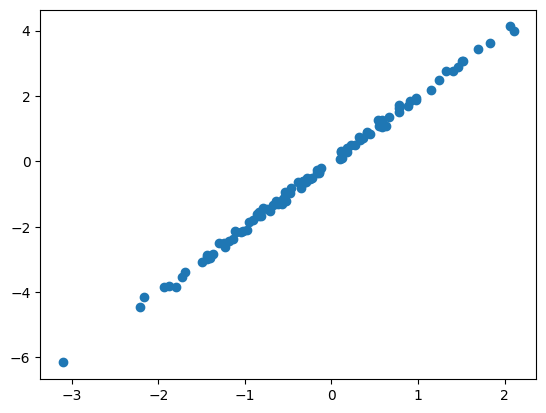

In [23]:
n = 100
x = th.randn(n, 1)
y = 2 * x + th.normal(size=(n, 1), mean=0, std=0.1)

plt.scatter(x.numpy()[:, 0], y.numpy()[:, 0])
plt.show()

Definimos las instancias de `Parameter` para $\mathbf{w}$ y $b$ las cuales inicializamos con valores aleatorios (normal con media 0 y desviación estándar 0.1) y con ceros, respectivamente.

In [24]:
w = nn.parameter.Parameter(th.normal(size=(1, 1), mean=0, std=0.1))
b = nn.parameter.Parameter(th.zeros(size=(1, 1)))
w, b

(Parameter containing:
 tensor([[0.0768]], requires_grad=True),
 Parameter containing:
 tensor([[0.]], requires_grad=True))

Definimos una función para producir un tensor de salidas a partir de un tensor de entradas, esto es,
$$
\hat{y} = b + \mathbf{w}^\top\mathbf{x}.
$$


In [25]:
def neurona_lineal(w, b, x):
  return x @ w + b

Ahora definimos nuestro ciclo de entrenamiento en el cual generamos la salida para cada entrada, calculamos los gradientes de $\mathbf{w}$ y $b$ respecto al error cuadrático medio usando la diferenciación automática de Tensorflow y finalmente actualizamos $\mathbf{w}$ y $b$ con la regla de actualización del descenso por gradiente:

$$
\boldsymbol{\theta}^{[t + 1]}   = \boldsymbol{\theta}^{[t]} - \alpha \nabla \mathcal{L}(\boldsymbol{\theta}^{[t]})
$$
donde
$$
\begin{align*}
\boldsymbol{\theta} & = \{\mathbf{w}, \mathbf{b}\}\\
\nabla \mathcal{L}(\boldsymbol{\theta}^{[t]}) & = \left[  \frac{\partial \mathcal{L}}{\partial  \theta_0^{[t]}}, \cdots , \frac{\partial \mathcal{L}}{\partial \theta_d^{[t]}}\right]
\end{align*}
$$    

A $\alpha$ se le conoce como tasa de aprendizaje.


In [26]:
tasa = 0.1
hist = []
for e in range(100):
  y_hat = neurona_lineal(w, b, x)
  ecm = th.mean((y - y_hat)**2)
  ecm.backward() # calcula los gradientes de los tensores

  # actualiza los parámetros in-place
  # (es necesario que esté dentro de ámbito no_grad)
  with th.no_grad():
    w.subtract_(tasa * w.grad)
    b.subtract_(tasa * b.grad)

    # Se limpian los gradientes para que no se acumulen
    w.grad.zero_()
    b.grad.zero_()

    hist.append(ecm.numpy())

Visualizamos el modelo.

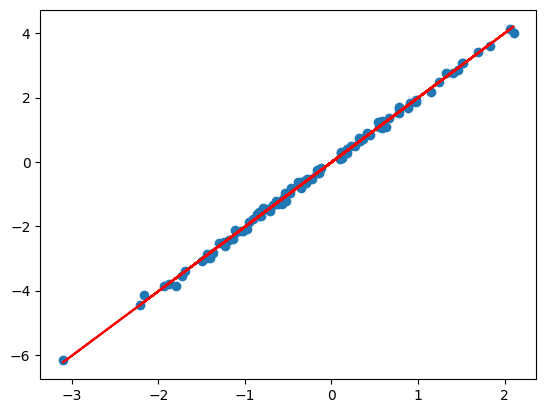

In [27]:
y_hat = neurona_lineal(w, b, x)

plt.scatter(x.numpy()[:, 0], y.numpy()[:, 0])
plt.plot(x.numpy()[:, 0], y_hat.detach().numpy()[:, 0], 'r')
plt.show()

Graficamos el valor de la pérdida por época.

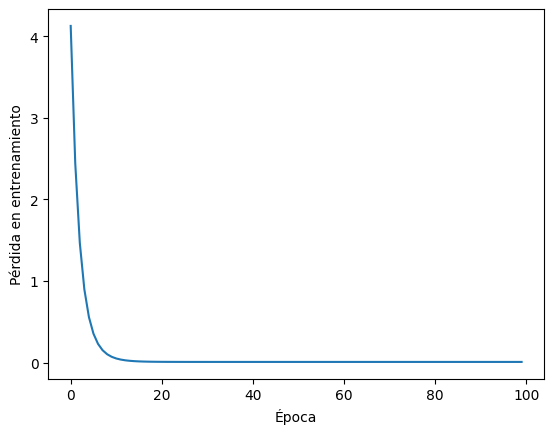

In [28]:
plt.plot(hist)
plt.xlabel('Época')
plt.ylabel('Pérdida en entrenamiento')
plt.show()

En el entrenamiento de redes neuronales profundas es común usar aproximaciones estocásticas del descenso por gradiente (o variaciones). Estas aproximaciones estiman $\nabla \mathcal{L}(\boldsymbol{\theta}^{[t]})$ y actualizan los parámetros (pesos y sesgos) usando un minilote $\mathcal{B}$ de ejemplos (en lugar de todo el conjunto) de entrenamiento, donde $\vert \mathcal{B} \vert$ es un hiperparámetro. Una estrategia para generar los lotes es dividir y ordenar aleatoriamente el conjunto de $n$ ejemplos de entrenamiento en $k$ minilotes ($\vert \mathcal{B} \vert \times k \approx n$) e ir tomando lotes consecutivos hasta pasar por todo el conjunto. Aquí una época ocurre cada vez que se han considerado los $k$ minilotes.

In [29]:
w = nn.parameter.Parameter(th.normal(size=(1, 1), mean=0, std=0.1))
b = nn.parameter.Parameter(th.zeros(size=(1, 1)))

tasa = 0.1
hist = []
t_lote = 10
n_lotes = 10
for e in range(100):
  perdida = 0
  # Generamos una permutación aleatoria del conjunto de entrenamiento
  perm = th.randperm(x.shape[0])
  xperm = x[perm]
  yperm = y[perm]

  # Vamos tomando lote por lote ejemplos del conjunto reordenado
  for lote in range(n_lotes):
    y_hat = neurona_lineal(w, b, xperm[lote * t_lote:(lote + 1) * t_lote])
    ecm = th.mean((yperm[lote * t_lote:(lote + 1) * t_lote] - y_hat)**2)
    ecm.backward() # calcula los gradientes de los tensores

      # actualiza los parámetros in-place
      # (es necesario que esté dentro de ámbito no_grad)
    with th.no_grad():
      w.subtract_(tasa * w.grad)
      b.subtract_(tasa * b.grad)

      # Se limpian los gradientes para que no se acumulen
      w.grad.zero_()
      b.grad.zero_()

      perdida += ecm.numpy()

    hist.append(perdida)

Visualizamos el modelo.

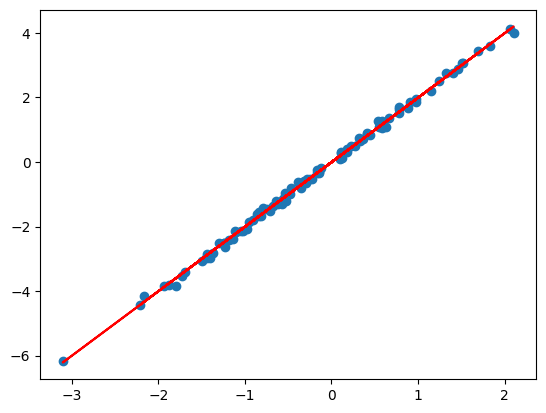

In [30]:
y_hat = neurona_lineal(w, b, x)

plt.scatter(x.numpy()[:, 0], y.numpy()[:, 0])
plt.plot(x.numpy()[:, 0], y_hat.detach().numpy()[:, 0], 'r')
plt.show()

Graficamos el valor de la pérdida por época.

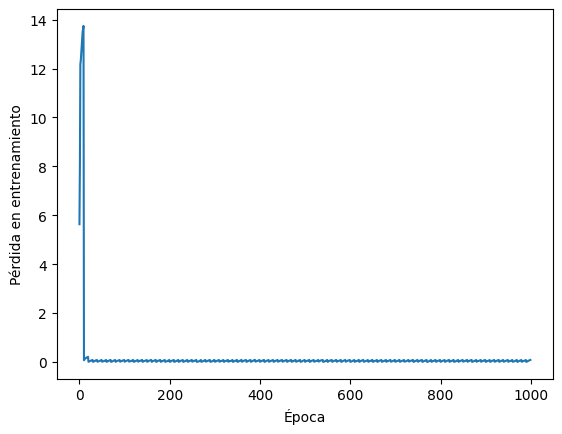

In [31]:
plt.plot(hist)
plt.xlabel('Época')
plt.ylabel('Pérdida en entrenamiento')
plt.show()